In [1]:
import os
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import OrdinalEncoder
from matplotlib.colors import ListedColormap


def download(PATH,local_name,format_offile):
    '''This function takes PATH which is url and local_name i.e the name of file after downloaded and format
    and downloads the file from web and stores in your path'''
    local_path=os.path.join("./",f'{local_name}.{format_offile}')
    urllib.request.urlretrieve(PATH,local_path)
    
def freedman(data):
    # freedman method for choosing no of bins
    data = np.asarray(data, dtype=np.float_)
    IQR = scipy.stats.iqr(data, rng=(25, 75), scale=1, nan_policy="omit")
    N = data.size
    bw = (2 * IQR) / np.power(N, 1/3)
    mini= np.min(data)
    maxi=np.max(data)
    d = maxi-mini
    result = int((d / bw) + 1)
    return result

In [2]:
# loading all csv files using pandas
PATH = '../datasets/'
Study_A = pd.read_csv(PATH+"Study_A.csv")
Study_B = pd.read_csv(PATH+"Study_B.csv")
Study_C = pd.read_csv(PATH+"Study_C.csv")
Study_D = pd.read_csv(PATH+"Study_D.csv")
Study_E = pd.read_csv(PATH+"Study_E.csv") 

# Treatment effect

<p>Does the (anonymized) treatment have an effect on schizophrenia? Your goal is to use the data to make a
case for or against the effect of treatment. Note that this objective is intentionally left somewhat ambiguous, as to give you flexibility on how to evaluate the treatment effect.</p>

In [3]:
all_studies = pd.concat([Study_A,Study_B,Study_C,Study_D,Study_E]) 
# considering all given studies as we have data of PANSS_Score and visit days for all studies 

In [4]:
all_studies["P_total"] = np.sum(np.array([all_studies[f"P{i}"] for i in range(1,8)]),axis=0)
all_studies["N_total"] = np.sum(np.array([all_studies[f"N{i}"] for i in range(1,8)]),axis=0)
all_studies["G_total"] = np.sum(np.array([all_studies[f"G{i}"] for i in range(1,17)]),axis=0)

In [5]:
all_studies_control = all_studies[all_studies["TxGroup"]=="Control"]
all_studies_treatment = all_studies[all_studies["TxGroup"]!="Control"]
# grouping all studies A,B...E depending on the treatment or control groups

In [6]:
all_studies["Country"].value_counts()

China             5960
USA               5164
Russia            3666
Japan             1800
Ukraine           1073
Czech Republic     762
Poland             612
Hungary            427
Spain              392
India              321
Slovakia           299
Argentina          279
Bulgaria           278
Portugal           245
Romania            239
Korea              187
Taiwan             182
Belgium            180
Germany            164
Mexico             149
Brazil             134
Canada             114
Greece              97
Australia           75
France              46
UK                  20
ERROR               18
Austria             16
Sweden              10
Name: Country, dtype: int64

In [7]:
ordinal_encoder = OrdinalEncoder()
arr = np.array(all_studies["Country"]).reshape(-1,1)
arr1 = np.array(all_studies["TxGroup"]).reshape(-1,1)
arr2 = np.array(all_studies["Study"]).reshape(-1,1)
encoded = ordinal_encoder.fit_transform(arr)
encoded1 = ordinal_encoder.fit_transform(arr1)
encoded2 = ordinal_encoder.fit_transform(arr2)
all_studies.loc[:,"Country"] = encoded
all_studies.loc[:,"TxGroup"] = encoded1
all_studies.loc[:,"Study"] = encoded2
# encoding all text categorial attributes into numbers using OrdinalEncoder from scikit-learn

C:\Users\Hamesh\AppData\Local\Temp\ipykernel_8544\1305227138.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_studies.loc[:,"Country"] = encoded
C:\Users\Hamesh\AppData\Local\Temp\ipykernel_8544\1305227138.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_studies.loc[:,"TxGroup"] = encoded1
C:\Users\Hamesh\AppData\Local\Temp\ipykernel_8544\1305227138.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, 

In [8]:
all_studies_control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11530 entries, 0 to 1961
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Study         11530 non-null  object
 1   Country       11530 non-null  object
 2   PatientID     11530 non-null  int64 
 3   SiteID        11530 non-null  int64 
 4   RaterID       11530 non-null  int64 
 5   AssessmentiD  11530 non-null  int64 
 6   TxGroup       11530 non-null  object
 7   VisitDay      11530 non-null  int64 
 8   P1            11530 non-null  int64 
 9   P2            11530 non-null  int64 
 10  P3            11530 non-null  int64 
 11  P4            11530 non-null  int64 
 12  P5            11530 non-null  int64 
 13  P6            11530 non-null  int64 
 14  P7            11530 non-null  int64 
 15  N1            11530 non-null  int64 
 16  N2            11530 non-null  int64 
 17  N3            11530 non-null  int64 
 18  N4            11530 non-null  int64 
 19  N5   

In [9]:
all_studies_treatment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11379 entries, 10 to 1953
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Study         11379 non-null  object
 1   Country       11379 non-null  object
 2   PatientID     11379 non-null  int64 
 3   SiteID        11379 non-null  int64 
 4   RaterID       11379 non-null  int64 
 5   AssessmentiD  11379 non-null  int64 
 6   TxGroup       11379 non-null  object
 7   VisitDay      11379 non-null  int64 
 8   P1            11379 non-null  int64 
 9   P2            11379 non-null  int64 
 10  P3            11379 non-null  int64 
 11  P4            11379 non-null  int64 
 12  P5            11379 non-null  int64 
 13  P6            11379 non-null  int64 
 14  P7            11379 non-null  int64 
 15  N1            11379 non-null  int64 
 16  N2            11379 non-null  int64 
 17  N3            11379 non-null  int64 
 18  N4            11379 non-null  int64 
 19  N5  

<p>We have all fields are not null and total number of rows from the above for treatment and control groups is 11530, 11379 and LeadStatus group has few less values(10524,10423) because for study E LeadStatus field should be predicted in further problem statement.</p>

In [10]:
all_studies.describe()

,Study,Country,PatientID,SiteID,RaterID,AssessmentiD,TxGroup,VisitDay,P1,P2,...,G11,G12,G13,G14,G15,G16,PANSS_Total,P_total,N_total,G_total
count,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,...,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000,22909.000000
mean,2.007901,16.807630,30633.481208,60224.140993,90382.462526,305387.675062,0.496704,89.957571,2.958663,2.673054,...,2.386049,3.207735,2.459252,1.803047,2.426383,2.652538,71.112096,16.396962,19.848793,34.866341
std,0.986454,8.473701,9883.579593,19728.216854,29596.641078,98758.258590,0.500000,92.961899,1.404361,1.235907,...,1.033906,1.211673,1.058141,0.972589,1.116864,1.185041,18.908947,6.472019,5.520974,9.586275
min,0.000000,0.000000,10001.000000,20001.000000,30001.000000,100001.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,7.000000,7.000000,16.000000
25%,2.000000,7.000000,30163.000000,60016.000000,90039.000000,301440.000000,0.000000,15.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,58.000000,11.000000,16.000000,28.000000
50%,2.000000,18.000000,30865.000000,60101.000000,90230.000000,307167.000000,0.000000,67.000000,3.000000,3.000000,...,2.000000,3.000000,3.000000,1.000000,2.000000,3.000000,69.000000,15.000000,20.000000,34.000000
75%,2.000000,27.000000,31529.000000,60187.000000,90407.000000,312894.000000,1.000000,129.000000,4.000000,3.000000,...,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,84.000000,21.000000,23.000000,41.000000
max,4.000000,28.000000,50513.000000,100061.000000,150139.000000,502370.000000,1.000000,480.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,166.000000,43.000000,46.000000,83.000000


In [11]:
#  we compute correlation of PANSS_score with respect to other attributes for all studies combined
all_s = all_studies.drop(["AssessmentiD","PatientID"],axis=1) 
# we know the above fields are just for identification nothing to do with PANSS score
corr_matrix = all_s.corr(numeric_only=True)
print(corr_matrix["PANSS_Total"].sort_values(ascending=False))

PANSS_Total    1.000000
G_total        0.956751
P_total        0.862717
N_total        0.752358
P1             0.734715
P6             0.729133
P2             0.723526
G9             0.696390
G15            0.684152
G16            0.674352
P3             0.630210
G11            0.617568
N2             0.606790
P4             0.601621
N7             0.598644
G4             0.595298
N4             0.584448
G2             0.580999
P7             0.577403
G8             0.566944
N3             0.565733
G13            0.563744
G14            0.557272
N6             0.513304
N1             0.498928
N5             0.487566
G10            0.463206
G5             0.462183
G12            0.458041
P5             0.449586
G6             0.438994
G7             0.402589
G1             0.358665
G3             0.352608
Country        0.170626
TxGroup        0.000104
Study         -0.355825
SiteID        -0.356116
RaterID       -0.356140
VisitDay      -0.575955
Name: PANSS_Total, dtype: float64


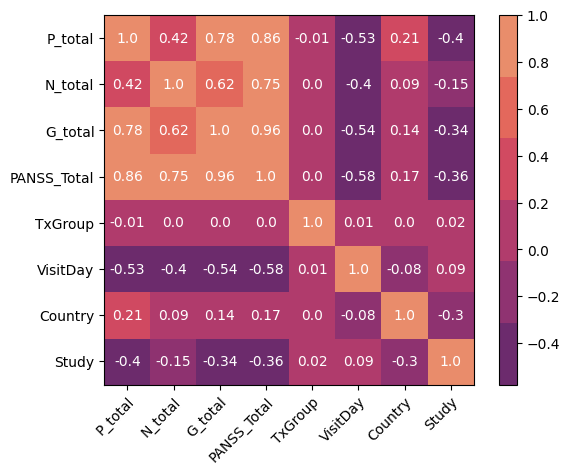

In [12]:
all_s = all_studies.loc[:,["P_total","N_total","G_total","PANSS_Total","TxGroup","VisitDay","Country","Study"]]
corr = all_s.corr()

# Create a figure and axes objects
fig, ax = plt.subplots()

flatui = [(0.42355299, 0.16934709, 0.42581586), 
          (0.56041794, 0.19845221, 0.44207535), 
          (0.69226314, 0.23413578, 0.42480327), 
          (0.81942908, 0.28911553, 0.38102921), 
          (0.888292, 0.40830288, 0.36223756), 
          (0.9155979, 0.55210684, 0.42070204)]
my_cmap = ListedColormap(flatui)

# Create heatmap using imshow
im = ax.imshow(corr, cmap=my_cmap)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels and rotation
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.index)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add annotations to heatmap
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        ax.text(j, i, round(corr.iloc[i, j], 2), ha="center", va="center", color="w")

### CHECKING FOR DATA FOR BOTH GROUPS ARE SIMILAR FOR FAIR COMPARISION

In [13]:
def kde_estimate(x,y,bw=0.8,kernel='gaussian'):
    '''Returns output of x for given fitted kernel density with y'''
    density=KernelDensity(kernel=kernel,bandwidth=bw).fit(y)
    scores=np.exp(density.score_samples(x))
    return scores

In [14]:
# first of all we are looking whether data given is unbiased for both the groups i.e there aren't case of more psycho 
# in standard medication and less in ananomyzed or vice-versa. So plotting PANSS,P_total,G_total,N_total on 0 visit day
# should help to decide whether inital data is unfair or not for further comparision
all_studies_treatment_initial = all_studies_treatment[all_studies_treatment["VisitDay"]==0] # rows with baseline measurement
all_studies_control_initial = all_studies_control[all_studies_control["VisitDay"]==0] 

Text(0.5, 1.0, 'Total PANSS Score distribution for both groups on 0th day')

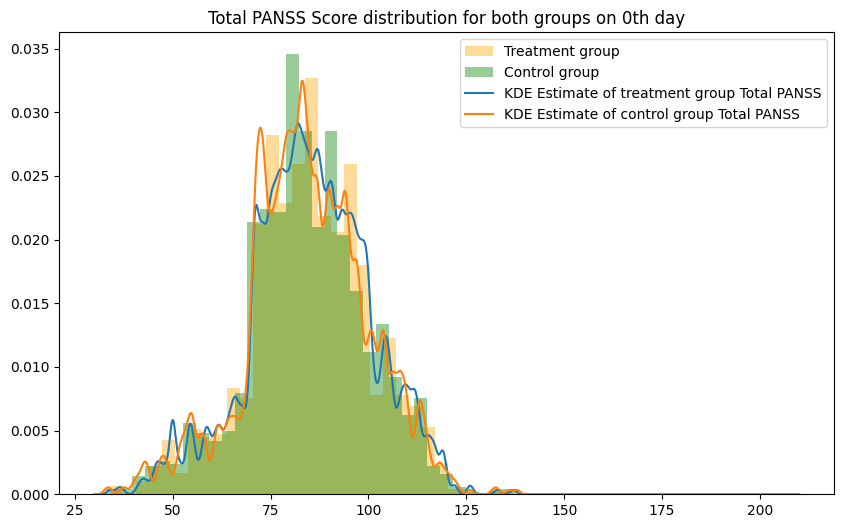

In [15]:
panss_treatment_0=np.array(all_studies_treatment_initial["PANSS_Total"]).reshape(-1,1)
panss_control_0=np.array(all_studies_control_initial["PANSS_Total"]).reshape(-1,1)

plt.figure(figsize=(10,6))
plt.hist(all_studies_treatment_initial["PANSS_Total"],bins=freedman(all_studies_treatment_initial["PANSS_Total"]),\
        label='Treatment group',color='orange',density=True,alpha=0.4)
plt.hist(all_studies_control_initial["PANSS_Total"],bins=freedman(all_studies_control_initial["PANSS_Total"]),\
         label='Control group',color='green',density=True,alpha=0.4)

x = np.linspace(30,210,10000) # min score possible is 30 (30*1) and maximum score is 210 (30*7)
y = np.linspace(30,210,10000)
kde_treatment = kde_estimate(x.reshape(-1,1),panss_treatment_0)
kde_control = kde_estimate(y.reshape(-1,1),panss_control_0)

plt.plot(x,kde_treatment,label='KDE Estimate of treatment group Total PANSS')
plt.plot(y,kde_control,label='KDE Estimate of control group Total PANSS')
plt.legend()
plt.title("Total PANSS Score distribution for both groups on 0th day")

Text(0.5, 1.0, 'Total Positive Score distribution for both groups on 0th day')

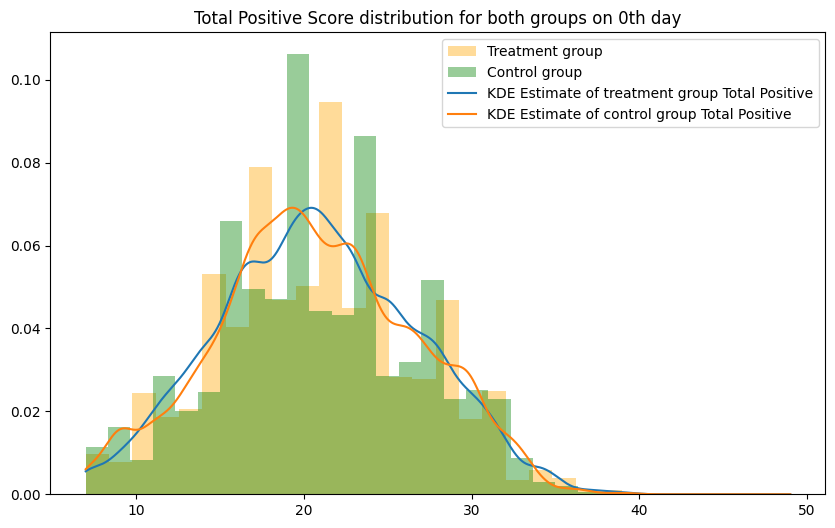

In [16]:
panss_treatment_0 = np.array(all_studies_treatment_initial["P_total"]).reshape(-1, 1)
panss_control_0 = np.array(all_studies_control_initial["P_total"]).reshape(-1, 1)

plt.figure(figsize=(10,6))
plt.hist(all_studies_treatment_initial["P_total"],bins=freedman(all_studies_treatment_initial["P_total"]),\
        label='Treatment group',color='orange',density=True,alpha=0.4)
plt.hist(all_studies_control_initial["P_total"],bins=freedman(all_studies_control_initial["P_total"]),\
         label='Control group',color='green',density=True,alpha=0.4)

x = np.linspace(7,49,10000) # min score possible is 7 (7*1) and maximum score is 49 (7*7)
y = np.linspace(7,49,10000)

kde_treatment = kde_estimate(x.reshape(-1,1),panss_treatment_0)
kde_control = kde_estimate(y.reshape(-1,1),panss_control_0)
plt.plot(x,kde_treatment,label='KDE Estimate of treatment group Total Positive')
plt.plot(y,kde_control,label='KDE Estimate of control group Total Positive')
plt.legend()
plt.title("Total Positive Score distribution for both groups on 0th day")

Text(0.5, 1.0, 'Total Negative Score distribution for both groups on 0th day')

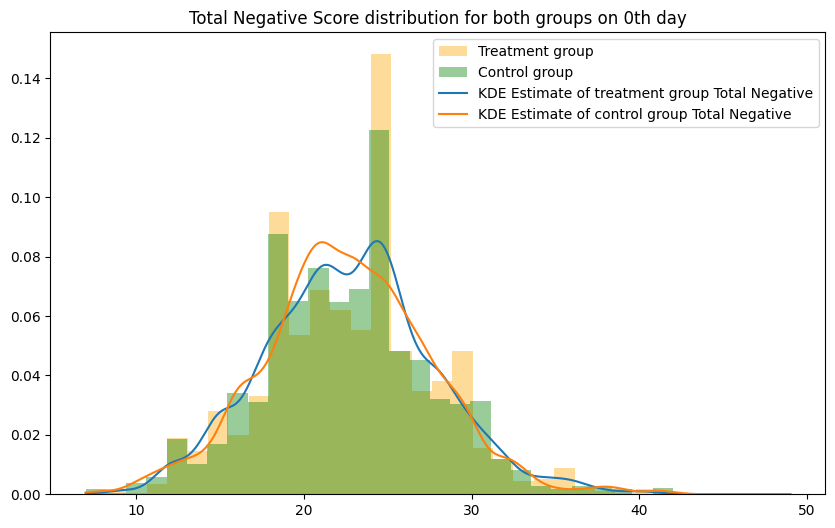

In [17]:
panss_treatment_0 = np.array(all_studies_treatment_initial["N_total"]).reshape(-1, 1)
panss_control_0 = np.array(all_studies_control_initial["N_total"]).reshape(-1, 1)

plt.figure(figsize=(10,6))
plt.hist(all_studies_treatment_initial["N_total"],bins=freedman(all_studies_treatment_initial["N_total"]),\
        label='Treatment group',color='orange',density=True,alpha=0.4)
plt.hist(all_studies_control_initial["N_total"],bins=freedman(all_studies_control_initial["N_total"]),\
         label='Control group',color='green',density=True,alpha=0.4)

x = np.linspace(7,49,10000)  # min score possible is 7 (7*1) and maximum score is 49 (7*7)
y = np.linspace(7,49,10000)

kde_treatment = kde_estimate(x.reshape(-1,1),panss_treatment_0)
kde_control = kde_estimate(y.reshape(-1,1),panss_control_0)

plt.plot(x,kde_treatment,label='KDE Estimate of treatment group Total Negative')
plt.plot(y,kde_control,label='KDE Estimate of control group Total Negative')
plt.legend()
plt.title("Total Negative Score distribution for both groups on 0th day")

Text(0.5, 1.0, 'Total General Score distribution for both groups on 0th day')

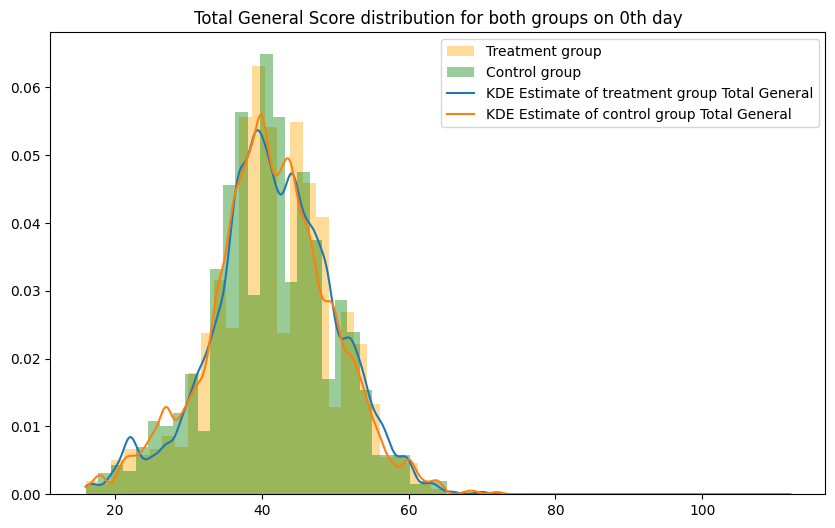

In [18]:
panss_treatment_0 = np.array(all_studies_treatment_initial["G_total"]).reshape(-1, 1)
panss_control_0 = np.array(all_studies_control_initial["G_total"]).reshape(-1, 1)

plt.figure(figsize=(10,6))
plt.hist(all_studies_treatment_initial["G_total"],bins=freedman(all_studies_treatment_initial["G_total"]),\
        label='Treatment group',color='orange',density=True,alpha=0.4)
plt.hist(all_studies_control_initial["G_total"],bins=freedman(all_studies_control_initial["G_total"]),\
         label='Control group',color='green',density=True,alpha=0.4)

x = np.linspace(16,112,10000) # min score possible is 16 (16*1) and maximum score is 112 (16*7)
y = np.linspace(16,112,10000)

kde_treatment = kde_estimate(x.reshape(-1,1),panss_treatment_0)
kde_control = kde_estimate(y.reshape(-1,1),panss_control_0)

plt.plot(x,kde_treatment,label='KDE Estimate of treatment group Total General')
plt.plot(y,kde_control,label='KDE Estimate of control group Total General')
plt.legend()
plt.title("Total General Score distribution for both groups on 0th day")

### USING P - VALUE TEST OF PEARSON CORRELATION

In [19]:
correlation,pvalue = scipy.stats.pearsonr(all_s["PANSS_Total"],all_s["TxGroup"])
print(f"p-value statistic for the above pearson correlation is {pvalue}")
print("According to p-value test .....")

if(pvalue<0.05):
    print(f"We reject null hypothesis that there isn't correlation between PANSS_Total and TxGroup")
else:
    print(f"We can't reject the null hypothesis that there isn't correlation between PANSS_Total and TxGroup")

p-value statistic for the above pearson correlation is 0.9874758254783604
According to p-value test .....
We can't reject the null hypothesis that there isn't correlation between PANSS_Total and TxGroup


In [20]:
correlation,pvalue = scipy.stats.pearsonr(all_s["P_total"],all_s["TxGroup"])
print(f"p-value statistic for the above pearson correlation is {pvalue}")
print("According to p-value test .....")

if(pvalue<0.05):
    print(f"We reject null hypothesis that there isn't correlation between PANSS_Total and TxGroup")
else:
    print(f"We can't reject the null hypothesis that there isn't correlation between PANSS_Total and TxGroup")

p-value statistic for the above pearson correlation is 0.17259486677725633
According to p-value test .....
We can't reject the null hypothesis that there isn't correlation between PANSS_Total and TxGroup


In [21]:
correlation,pvalue = scipy.stats.pearsonr(all_s["N_total"],all_s["TxGroup"])
print(f"p-value statistic for the above pearson correlation is {pvalue}")
print("According to p-value test .....")

if(pvalue<0.05):
    print(f"We reject null hypothesis that there isn't correlation between PANSS_Total and TxGroup")
else:
    print(f"We can't reject the null hypothesis that there isn't correlation between PANSS_Total and TxGroup")

p-value statistic for the above pearson correlation is 0.48227192969726224
According to p-value test .....
We can't reject the null hypothesis that there isn't correlation between PANSS_Total and TxGroup


In [22]:
correlation,pvalue = scipy.stats.pearsonr(all_s["G_total"],all_s["TxGroup"])
print(f"p-value statistic for the above pearson correlation is {pvalue}")
print("According to p-value test .....")

if(pvalue<0.05):
    print(f"We reject null hypothesis that there isn't correlation between PANSS_Total and TxGroup")
else:
    print(f"We can't reject the null hypothesis that there isn't correlation between PANSS_Total and TxGroup")

p-value statistic for the above pearson correlation is 0.584312086052177
According to p-value test .....
We can't reject the null hypothesis that there isn't correlation between PANSS_Total and TxGroup


### CONCLUSIONS FROM VERSUS PLOTS 

In [23]:
z1 = lowess(all_studies_treatment["PANSS_Total"],all_studies_treatment["VisitDay"])# locally weighted linear regression 
z2 = lowess(all_studies_control["PANSS_Total"],all_studies_control["VisitDay"])

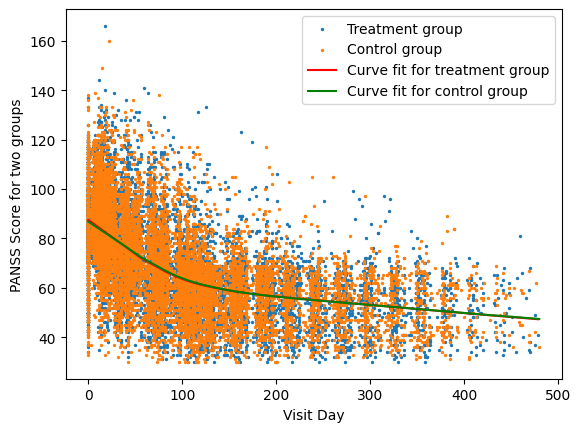

In [24]:
plt.scatter(all_studies_treatment["VisitDay"],all_studies_treatment["PANSS_Total"],s=2,label='Treatment group')
plt.scatter(all_studies_control["VisitDay"],all_studies_control["PANSS_Total"],s=2,label='Control group')
plt.plot(z1[:,0],z1[:,1],label='Curve fit for treatment group',color='red')
plt.plot(z2[:,0],z2[:,1],label='Curve fit for control group',color='green')
plt.xlabel("Visit Day")
plt.ylabel("PANSS Score for two groups")
plt.legend()

In [25]:
z1 = lowess(all_studies_treatment["P_total"],all_studies_treatment["VisitDay"])# locally weighted linear regression 
z2 = lowess(all_studies_control["P_total"],all_studies_control["VisitDay"])

In [26]:
h1 = lowess(all_studies_treatment["N_total"],all_studies_treatment["VisitDay"])# locally weighted linear regression 
h2 = lowess(all_studies_control["N_total"],all_studies_control["VisitDay"])

In [27]:
g1 = lowess(all_studies_treatment["G_total"],all_studies_treatment["VisitDay"])# locally weighted linear regression 
g2 = lowess(all_studies_control["G_total"],all_studies_control["VisitDay"])

Text(0.5, 0.98, 'Total Positive, Negative, General scale scores vs visit day for two groups')

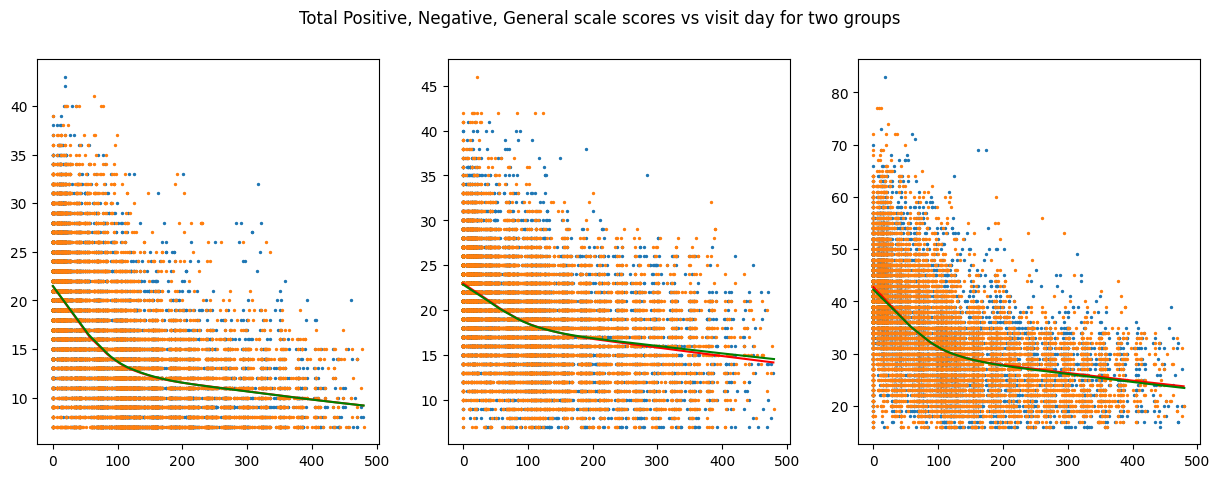

In [28]:
fig,ax=plt.subplots(ncols=3,figsize=(15,5))

ax[0].scatter(all_studies_treatment["VisitDay"],all_studies_treatment["P_total"],s=2,label='Treatment group')
ax[0].scatter(all_studies_control["VisitDay"],all_studies_control["P_total"],s=2,label='Control group')
ax[0].plot(z1[:,0],z1[:,1],label='Curve fit for treatment group total positive scale',color='red')
ax[0].plot(z2[:,0],z2[:,1],label='Curve fit for control group total positive scale',color='green')
ax[1].scatter(all_studies_treatment["VisitDay"],all_studies_treatment["N_total"],s=2,label='Treatment group')
ax[1].scatter(all_studies_control["VisitDay"],all_studies_control["N_total"],s=2,label='Control group')
ax[1].plot(h1[:,0],h1[:,1],label='Curve fit for treatment group total negative scale',color='red')
ax[1].plot(h2[:,0],h2[:,1],label='Curve fit for control group total negative scale',color='green')
ax[2].scatter(all_studies_treatment["VisitDay"],all_studies_treatment["G_total"],s=2,label='Treatment group')
ax[2].scatter(all_studies_control["VisitDay"],all_studies_control["G_total"],s=2,label='Control group')
ax[2].plot(g1[:,0],g1[:,1],label='Curve fit for treatment group total General scale',color='red')
ax[2].plot(g2[:,0],g2[:,1],label='Curve fit for control group total General scale',color='green')
plt.suptitle("Total Positive, Negative, General scale scores vs visit day for two groups")
# ax[0].legend()
# ax[1].legend()
# ax[2].legend()

### CONCLUSIONS FROM CURVE FITTING AND P-VALUE TEST

In [29]:
def line_fit(x,a,b,c):
    return a+c*x["TxGroup"]*x["VisitDay"]+b*x["VisitDay"]

def return_pvalues(popt,pcov):
    perr = np.sqrt(np.diag(pcov))
    p_values = 2 * (1 - scipy.stats.norm.cdf(np.abs(popt / perr)))
    return p_values

In [30]:
ydata = all_studies["PANSS_Total"] 
popt,pcov= scipy.optimize.curve_fit(line_fit,all_studies,ydata)
print("Optimal parameters for linear regression by considering TxGroup and Visit Day along with bias term as features",popt)
p_values = return_pvalues(popt,pcov)
print(p_values)

Optimal parameters for linear regression by considering TxGroup and Visit Day along with bias term as features [ 8.16507988e+01 -1.17045454e-01 -2.12674322e-04]
[0.         0.         0.89286067]


<p>For coefficient of TxGroup field we have p value as 0.8928 which means that we can't reject the hypothesis that coefficient for treatment corresponding to TxGroup = 1 i.e anonymized treatment is close to 0. It is as likely as 89.28% chance for that coefficient that differentiates between two treatments is close to 0 (-0.000213). Similarly we can check for total positive score, negative score etc.</p>

In [31]:
ydata = all_studies["P_total"] 
popt,pcov= scipy.optimize.curve_fit(line_fit,all_studies,ydata)
print("Optimal parameters for linear regression by considering TxGroup and Visit Day along with bias term as features",popt)
p_values = return_pvalues(popt,pcov)
print(p_values)

Optimal parameters for linear regression by considering TxGroup and Visit Day along with bias term as features [ 1.97352229e+01 -3.69591672e-02 -2.99839170e-04]
[0.         0.         0.59194346]


In [32]:
ydata = all_studies["N_total"] 
popt,pcov= scipy.optimize.curve_fit(line_fit,all_studies,ydata)
print("Optimal parameters for linear regression by considering TxGroup and Visit Day along with bias term as features",popt)
p_values = return_pvalues(popt,pcov)
print(p_values)

Optimal parameters for linear regression by considering TxGroup and Visit Day along with bias term as features [ 2.20111724e+01 -2.39253976e-02 -2.24449812e-04]
[0.        0.        0.6634041]


In [33]:
ydata = all_studies["G_total"] 
popt,pcov= scipy.optimize.curve_fit(line_fit,all_studies,ydata)
print("Optimal parameters for linear regression by considering TxGroup and Visit Day along with bias term as features",popt)
p_values = return_pvalues(popt,pcov)
print(p_values)

Optimal parameters for linear regression by considering TxGroup and Visit Day along with bias term as features [ 3.99044036e+01 -5.61608909e-02  3.11617233e-04]
[0.         0.         0.70470387]
